In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf

In [196]:
ticker = "ICICIBANK.NS"
data = yf.download(ticker, start="2013-07-06", end="2023-07-06")

[*********************100%***********************]  1 of 1 completed


In [197]:
def keltner_channel(data,atr_lookback=10,kc_lookback=20,multiplier=2):
    high = data['High']
    low = data['Low']
    close = data['Adj Close']
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr
    
    return kc_middle, kc_upper, kc_lower

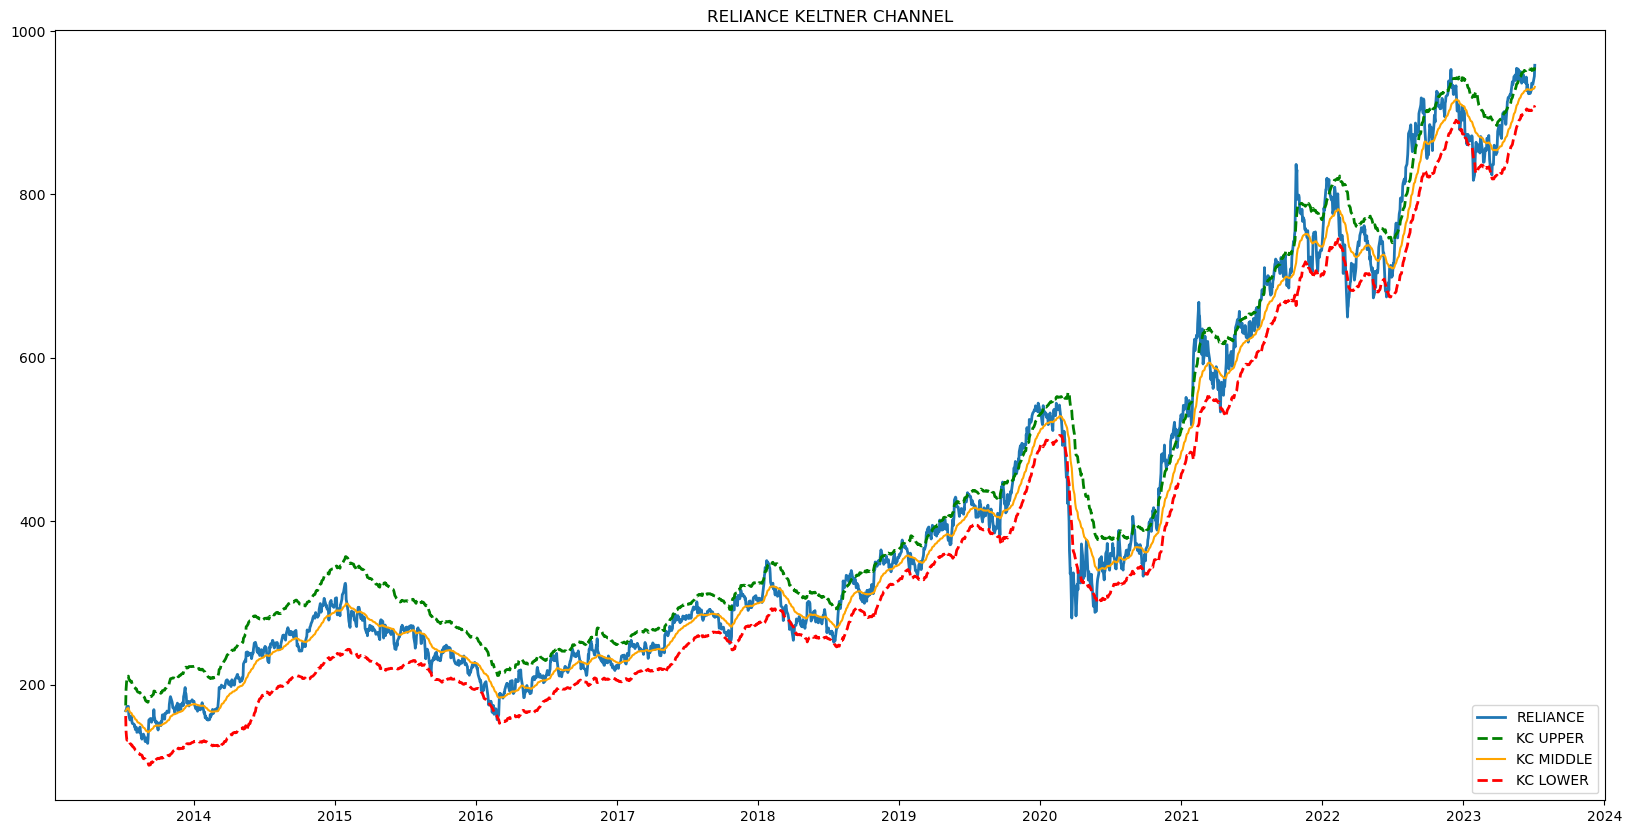

In [198]:
middle_kc, upper_kc, lower_kc = keltner_channel(data)
plt.figure(figsize=(20,10))
plt.plot(data['Adj Close'], linewidth = 2, label = 'RELIANCE')
plt.plot(upper_kc, linewidth = 2, color = 'green', linestyle = '--', label = 'KC UPPER')
plt.plot(middle_kc, linewidth = 1.5, color = 'orange', label = 'KC MIDDLE')
plt.plot(lower_kc, linewidth = 2, color = 'red', linestyle = '--', label = 'KC LOWER')
plt.legend(loc = 'lower right')
plt.title('RELIANCE KELTNER CHANNEL')
plt.show()

In [199]:
def is_hammer(candle):
    body_length = abs(candle['Close'] - candle['Open'])
    shadow_length = candle['High'] - max(candle['Close'], candle['Open'])
    return body_length <= 2 * shadow_length and shadow_length >= 2 * body_length

In [200]:
data['UpperBand'] = upper_kc
data['LowerBand'] = lower_kc


def generate_signals(data):
    signals = pd.DataFrame(index=data.index)
    signals['Signal'] = 0

    for i in range(2, len(data)):
        current_candle = data.iloc[i]
        prev_candle = data.iloc[i - 1]
        threshold1 = current_candle['UpperBand']/100.0
        threshold2 = current_candle['LowerBand']/20.0
        
        if is_hammer(current_candle):
            difference = current_candle['Close'] - current_candle['UpperBand']
            if abs(difference) <= threshold1:
                signals.loc[data.index[i], 'Signal'] = -1  # Sell signal
                
        
        if is_hammer(current_candle):
            difference = current_candle['Close'] - current_candle['LowerBand']
            if abs(difference) <= threshold2:
                signals.loc[data.index[i], 'Signal'] = 1  # Buy signal

    return signals

signals = generate_signals(data)

In [201]:
candlestick = go.Candlestick(
    x=data.index,
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close']
)

fig = go.Figure()

fig.add_trace(candlestick)

fig.add_trace(go.Scatter(
    x=data.index, y=middle_kc,
    mode='lines',
    name='KC MIDDLE',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=data.index, y=upper_kc,
    mode='lines',
    name='KC UPPER',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=data.index, y=lower_kc,
    mode='lines',
    name='KC LOWER',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=signals[signals['Signal'] == 1].index,
    y=data.loc[signals['Signal'] == 1, 'Close'],
    mode='markers',
    marker=dict(symbol="triangle-up", color="green"),
    name='Buy Signals'
))

fig.add_trace(go.Scatter(
    x=signals[signals['Signal'] == -1].index,
    y=data.loc[signals['Signal'] == -1, 'Close'],
    mode='markers',
    marker=dict(symbol="triangle-down", color="red"),
    name='Sell Signals'
))

fig.update_layout(
    title='KELTNER CHANNEL TRADING SIGNALS',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    showlegend=True
)

fig.show()


In [202]:
def evaluate_strategy(data, signals):
    
    data['Return'] = data['Close'].pct_change()
    
    signals['Return'] = data['Return'] * signals['Signal'].shift()

    signals['CumulativeReturn'] = (1 + signals['Return']).cumprod()

    rolling_max = signals['CumulativeReturn'].cummax()
    signals['Drawdown'] = (signals['CumulativeReturn'] / rolling_max) - 1
    max_drawdown = signals['Drawdown'].min()

    sharpe_ratio = np.sqrt(252) * (signals['Return'].mean() / signals['Return'].std())

    return max_drawdown, sharpe_ratio, signals['CumulativeReturn'].iloc[-1]

In [203]:
max_drawdown, sharpe_ratio, cumulative_return = evaluate_strategy(data, signals)

print("Max Drawdown:", max_drawdown)
print("Sharpe Ratio:", sharpe_ratio)
print("Cumulative Return:", cumulative_return)

Max Drawdown: -0.19447295758947347
Sharpe Ratio: 0.48814097726360983
Cumulative Return: 1.3449016178512996
